# Labeling and clustering script 

In [1]:
# imports and function definitions
import numpy as np
import pandas as pd
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import sys

import sklearn
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

def ClusterKmeans(data, n):
    """Clusters the data into n clusters."""
    return KMeans(n, random_state = 52).fit_predict(data)

def plotting(cluster_data, n_clusters, cluster_recolor=None):
    """Plots 2D visualizations of the clustered data using PCA and tSNE."""

    cluster_number = len(n_clusters)
    fig, axs = plt.subplots(2, cluster_number, figsize=(6*cluster_number,10))

    # for color mapping
    t = plt.get_cmap('tab20')
    vf = np.vectorize(lambda c: mc.to_hex(t.colors[c]))

    for i in range(cluster_number):
        pca_data = cluster_data['pca']
        tsne_data = cluster_data['tsne']
        if cluster_recolor is None:
            cluster_colors = vf(cluster_data[str(n_clusters[i])])
            cluster_alphas = np.ones(len(cluster_colors))
        else:
            cluster_colors = vf(cluster_recolor['colors'])
            cluster_alphas = cluster_recolor['alphas']


        axs[0][i].scatter(pca_data[:,0],pca_data[:,1], c = cluster_colors, alpha = cluster_alphas)
        axs[1][i].scatter(tsne_data[:,0],tsne_data[:,1], c=cluster_colors, alpha = cluster_alphas)

        axs[0][i].set_title('PCA dimensions')
        axs[1][i].set_title('tSNE dimensions')
        axs[0][i].set_xlabel('Component 1')
        axs[1][i].set_xlabel('Component 1')
        axs[0][i].set_ylabel('Component 2')
        axs[1][i].set_ylabel('Component 2')

    plt.savefig('clusters_recolor.svg')

def cluster_variation(data, cluster_labels):
    """Computes and plots the silhouette scores for varying numbers of clusters,
    aiming to evaluate cluster validity."""

    # silhouette score
    scores = []
    for n in list(cluster_labels.keys())[2:]:
        v = silhouette_score(X=data,labels=cluster_labels[n])
        scores.append(v)
        # save each silhouette score vector, and return avg. of them all
        # as a measure of overall "distance"
    fig,ax = plt.subplots(1)
    print(cluster_labels.keys())
    print(scores)

    xs = [k for k in cluster_labels.keys()][:-1]
    ys = scores[:-1]
    
    ax.plot(xs[2:],ys,'o',linestyle='solid')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette score')

    plt.savefig('silhouette.svg')

    return scores



def run_clusters(filename, n_clusters):
    """Reads a CSV file of data, applies PCA and tSNE dimensionality reductions,
    performs KMeans clustering for a list of specified cluster numbers, and
    plots the results."""

    weights = pd.read_csv('weights.csv',index_col=[0]).drop('ligand_gnina_types',axis=1)
    new_index = [i[2] for i in weights.index.str.split('/')]
    weights.insert(0,'PDB',new_index)
    weights_labeled = weights.set_index('PDB')
    weights = weights_labeled.values

    pca = PCA(n_components = 2, random_state = 52).fit_transform(weights)
    tsne = TSNE(n_components = 2, random_state = 52).fit_transform(weights)
    cluster_data = {'pca': pca, 'tsne': tsne}

    for n in n_clusters:
        kmeans = ClusterKmeans(weights, n)
        cluster_data[str(n)] = kmeans
    plotting(cluster_data, n_clusters)
    return cluster_data, weights_labeled


/Users/jdurrant/opt/anaconda3/envs/cenfigs/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jdurrant/opt/anaconda3/envs/cenfigs/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jdurrant/opt/anaconda3/envs/cenfigs/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jdurrant/opt/anaconda3/envs/cenfigs/lib/python3.9/site-packages/sklearn/cluster/_kme

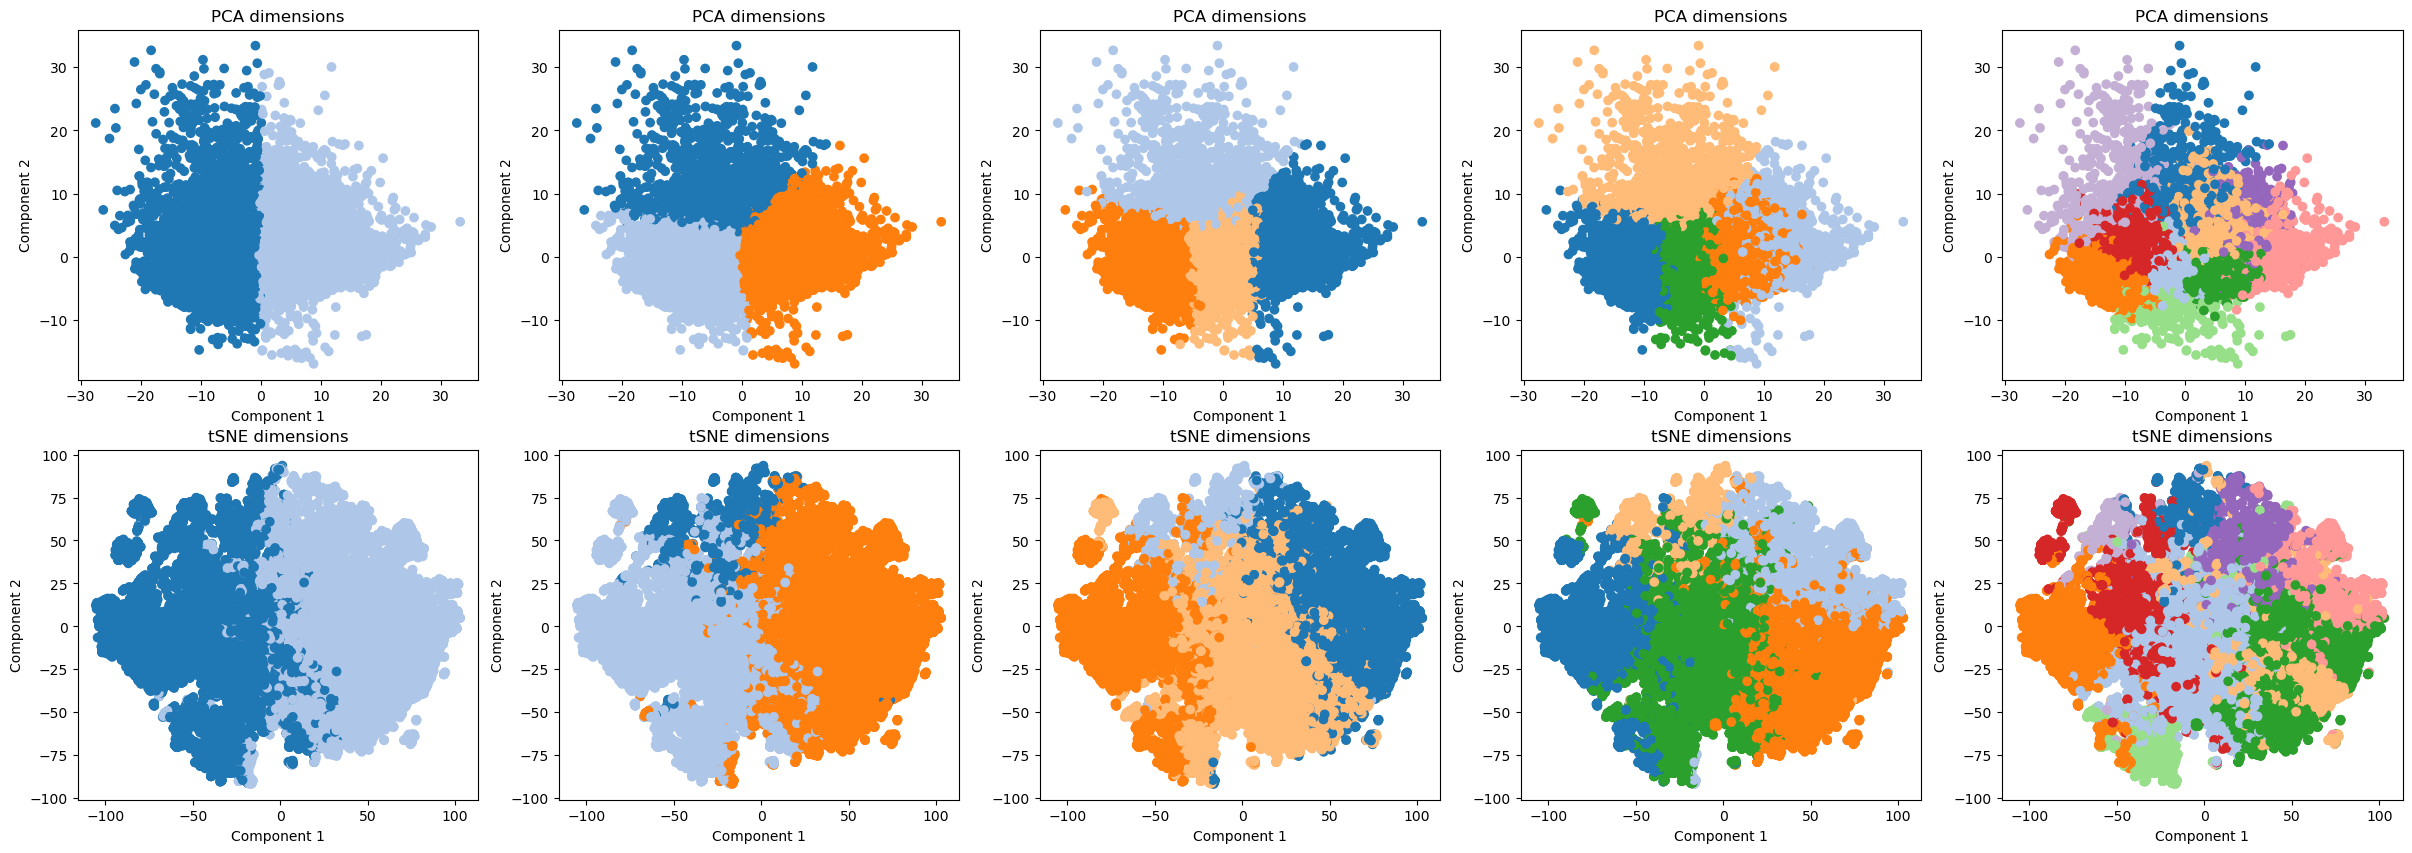

In [2]:
# get clustered weights and all data clusters plot.
# All files needed for this: weights.csv (all rescored weights), pdbs_list.txt (all pdb IDs in dataset, optional)
filename = 'weights.csv'
n_clusters = [2,3,4,5,10]

cluster_weight_data = run_clusters(filename, n_clusters)
# index 0 is clusters and dim.red., index 1 is weights with PDB labels

dict_keys(['pca', 'tsne', '2', '3', '4', '5', '10'])
[0.2387771068265662, 0.2361432786916241, 0.15624840534497575, 0.13707390598549565, 0.13149589801014297]


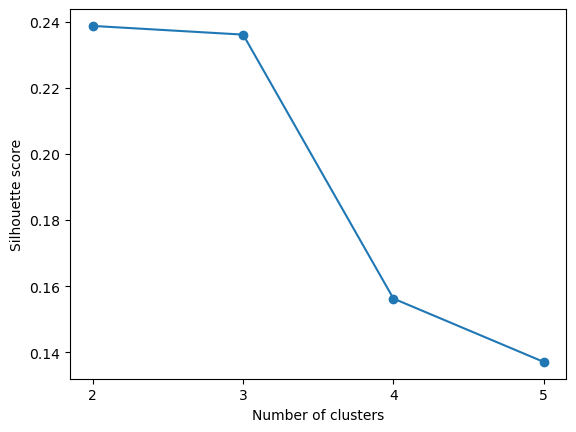

In [3]:
# get silhouette values
xs = cluster_weight_data[1]
ys = cluster_weight_data[0]
values = cluster_variation(xs, ys)

In [ ]:
values

[0.2387771068265662,
 0.2361432786916241,
 0.15624840534497575,
 0.13707390598549565,
 0.13149589801014297]

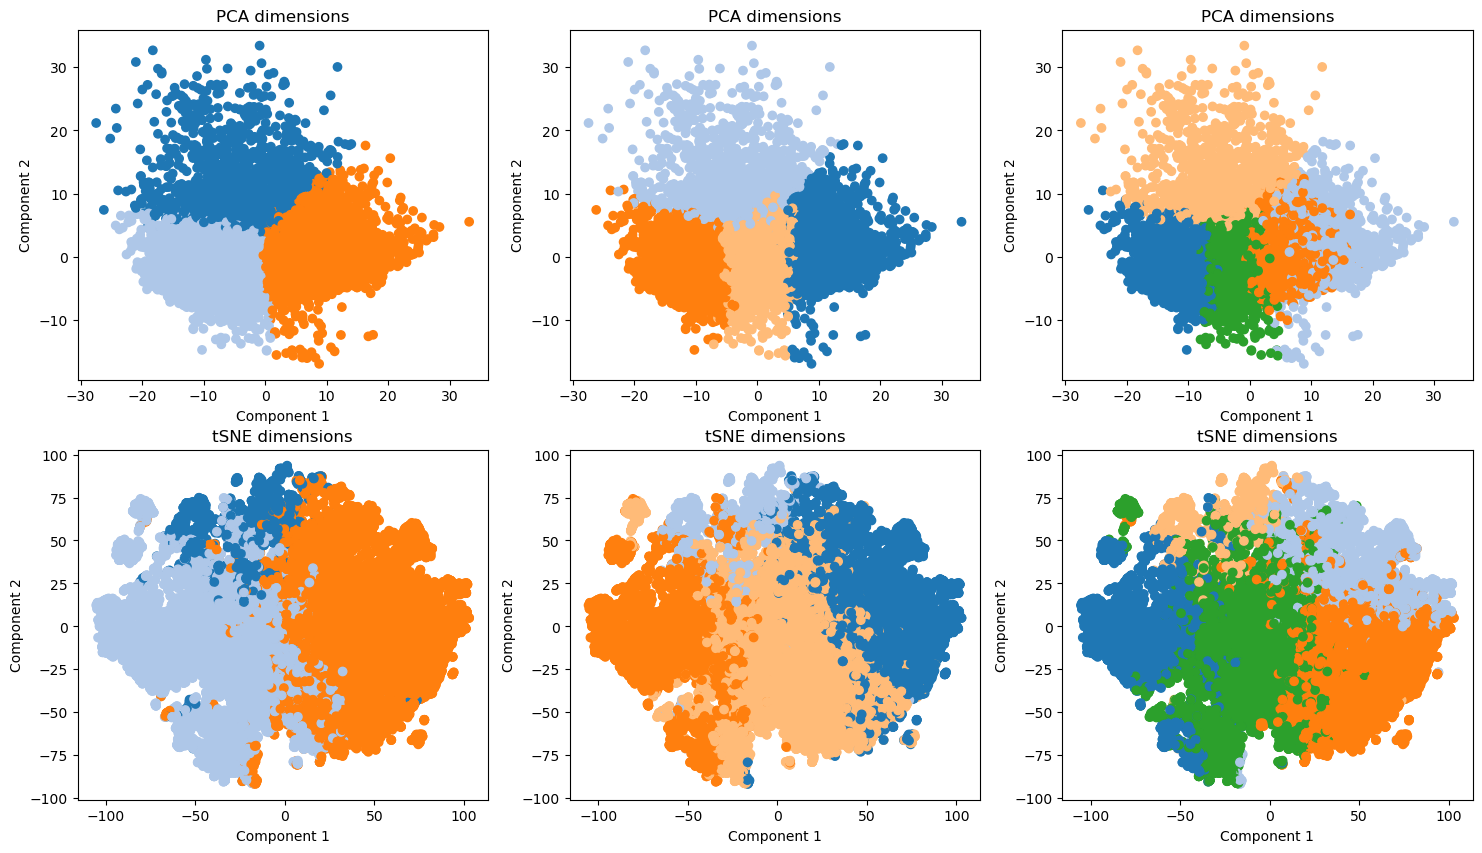

In [4]:
# get data labeled by cluster (n_clusters = ; n_data = 1262)
plotting(cluster_weight_data[0], [3,4,5])

In [10]:
def recolor_clusters_scop(cluster_data):
    """Uses SCOP family labels to recolor the clustered data points and returns
    a dictionary with the recolored labels and their corresponding opacities
    (alphas)."""
    
    # get scop data
    scop_data = pd.read_csv('scop-cla-latest.txt',delimiter='\s',skiprows=6,usecols=[0,1,10],names=['SCOP','PDB','Family'])
    scop_pdbs = scop_data['PDB']

    # Note that some PDBs appear multiple times in the scop csv file. This is
    # because they include multiple proteins (or chains) belonging to different
    # SCOP classifications. We don't know when one invovles the ligand CENet was
    # trained on, so let's just throw these out to avoid ambiguity.
    scop_pdb_counts = scop_pdbs.value_counts()
    scop_pdbs_to_use = scop_pdb_counts[scop_pdb_counts == 1].index

    # get PDBs in CENet dataset
    _, weights_labeled = cluster_data
    pdbs_in_censet = weights_labeled.index.str.upper()

    # Create scop_data_overlaps_cen as a copy of scop_data
    scop_data_overlaps_cen = scop_data.copy()

    # Delete rows from scop_data_overlaps_cen where the PDB is not in scop_pdbs_to_use
    scop_data_overlaps_cen = scop_data_overlaps_cen[scop_data_overlaps_cen['PDB'].isin(scop_pdbs_to_use)]

    # Further delete rows from scop_data_overlaps_cen where the PDB is not in
    # the CENet dataset. Note that this reduces the number of rows in
    # scop_data_overlaps_cen to only 916. It seems to be a bug to me, but I
    # saved the PDBs to two files and verified that's the overlap.
    scop_data_overlaps_cen = scop_data_overlaps_cen[scop_data_overlaps_cen['PDB'].isin(pdbs_in_censet)]

    # Add in the family id
    families = [
        row[4].split('=')[1] for row in scop_data_overlaps_cen['Family'].str.split(',')
    ]
    scop_data_overlaps_cen.insert(3,'FAM_ID',families)

    # plotted/clustered data are indexed same order as labeled weights.
    # Get the top 5 most common families for plotting
    # recolor_dict = scop_data_overlaps_cen['FAM_ID'].value_counts()[:5].to_dict()
    recolor_dict = scop_data_overlaps_cen['FAM_ID'].value_counts()[5:10].to_dict()

    # Get the ids of the biggest families
    biggest_family_ids = [k for k in recolor_dict.keys()]
    color_int_ids = range(1,len(biggest_family_ids)+1)

    # Get the counts of the biggest families
    biggest_family_counts = list(recolor_dict.values())

    # Instead of mapping to the count, remap to a range of 1-5 (for coloring)
    recolor_dict.update(zip(biggest_family_ids,color_int_ids))

    # Get color information too.
    t = plt.get_cmap('tab20')
    biggest_family_colors = [mc.to_hex(t.colors[i]) for i in color_int_ids]

    # Get the human-readable family names, too
    with open("scop-des-latest.txt") as f:
        id_to_name = {}
        for line in f:
            if line.startswith("#"):
                continue
            line = line.split()
            id_to_name[line[0]] = " ".join(line[1:])
    biggest_family_names = [id_to_name[i] for i in biggest_family_ids]

    # Now get the full text label
    biggest_family_labels = [f"{i} ({j})" for i,j in zip(biggest_family_names,biggest_family_counts)]
    
    recolor_labels = []
    pdb_pts = []
    for pdbid in weights_labeled.index.str.upper():
        mapping = scop_data_overlaps_cen[scop_data_overlaps_cen['PDB'] == pdbid]
        if mapping.empty:
            # if the PDB is not in the scop data, make it invisible (alpha = 0)
            recolor_labels.append([0,0.0])
        else:
            pdb_pts.append(pdbid)
            try:
                # if the PDB is in the scop data, color it according to the
                # recolor_dict
                recolor_labels.append([recolor_dict[mapping['FAM_ID'].values[0]],1.0])
            except Exception:
                # if the PDB is in the scop data but not in the recolor_dict,
                # color it gray
                # recolor_labels.append([19,0.1])
                recolor_labels.append([19,0.075])
    recolor_labels = np.array(recolor_labels)

    recolor = {'colors': recolor_labels[:,0].astype(int),'alphas': recolor_labels[:,1]}
    plotting(cluster_data[0],[3,5],cluster_recolor=recolor)
    return recolor, biggest_family_colors, biggest_family_labels, pdb_pts



/var/folders/n3/qms18y6d10v7mzmv_y1ph02c0000gn/T/ipykernel_27121/649651669.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  scop_data = pd.read_csv('scop-cla-latest.txt',delimiter='\s',skiprows=6,usecols=[0,1,10],names=['SCOP','PDB','Family'])


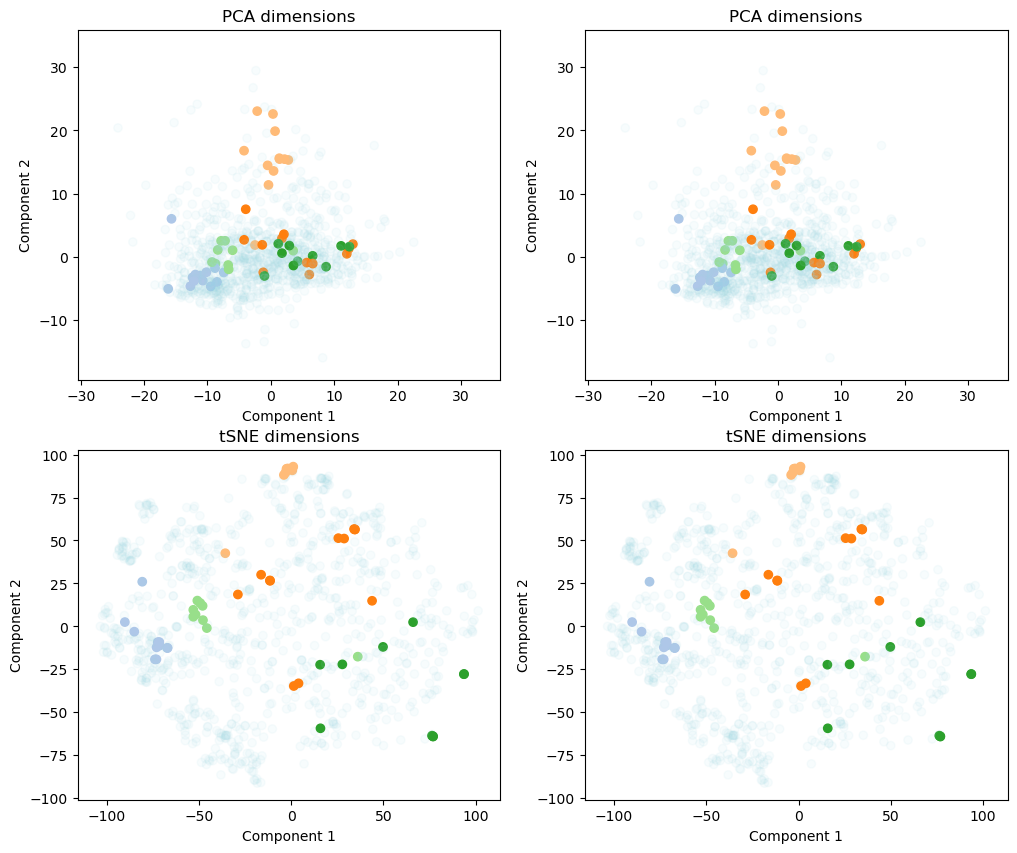

In [11]:
# get scop only data labeled by scop value (n_clusters = ; n_data = 1262)
recolor, biggest_family_colors, biggest_family_labels, pdb_pts = recolor_clusters_scop(cluster_weight_data)

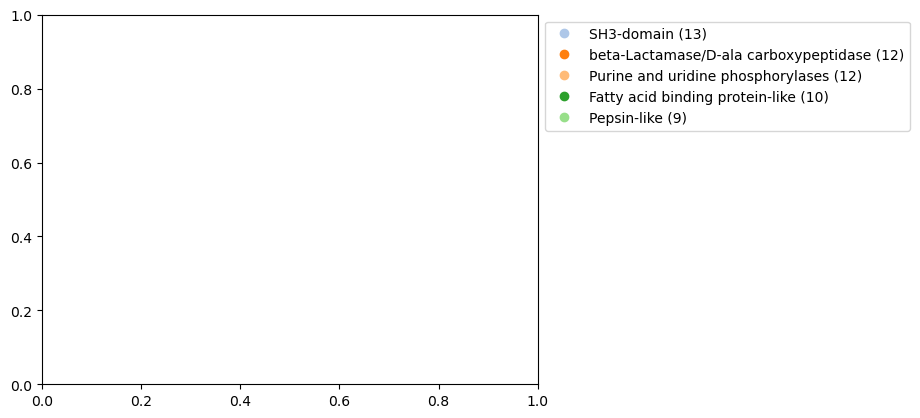

In [12]:
# Make the legend here

# Create a legend for the figure, using the color and label information for
# the biggest families
legend = []
for i in range(len(biggest_family_colors)):
    legend.append(plt.Line2D([0],[0],marker='o',color=biggest_family_colors[i],label=biggest_family_labels[i],linestyle='None'))
plt.legend(handles=legend,loc='upper left',bbox_to_anchor=(1,1))
plt.savefig('clusters_recolor_legend.svg',bbox_inches='tight')

In [ ]:
# print(recolor["colors"])
# print(cluster_weight_data[0]["tsne"])

# print(len(recolor["colors"]))
# print(len(pdb_pts))

data = []
j = 0
for t in range(len(recolor["colors"])):
    color = recolor["colors"][t]
    if color == 0:
        continue

    pt = cluster_weight_data[0]["tsne"][t]
    pdb = pdb_pts[j]
    if color != 19:
        data.append([pt[0], pt[1], color, pdb])
    j = j + 1

# Save the data to a csv file, using pure python
with open("tsne_data.csv", "w") as f:
    f.write("x,y,color,pdb\n")
    for d in data:
        f.write(f"{d[0]},{d[1]},{d[2]},{d[3]}\n")